In [260]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def cumprod_exclusive(
  tensor: torch.Tensor
) -> torch.Tensor:
  r"""
  (Courtesy of https://github.com/krrish94/nerf-pytorch)

  Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

  Args:
  tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
    is to be computed.
  Returns:
  cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
    tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
  """

  # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
  cumprod = torch.cumprod(tensor, 1)
  # "Roll" the elements along dimension 'dim' by 1 element.
  cumprod = torch.roll(cumprod, 1, 1)
  # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
  cumprod[..., 0] = 1.
  
  return cumprod

def sample_points_weighted(rays, sigma_value, distances, num_samples, fine_samples):
    num_total = num_samples + fine_samples
    points = rays[:, None, :3]
    points = torch.tensor(points, device = sigma_value.device, dtype = torch.float32)
    directions = rays[:, None, 3:]
    directions = torch.tensor(directions, device = sigma_value.device, dtype = torch.float32)
    distances = distances[:, :]
    interval_lengths = distances[:, 1:] - distances[:, :-1]

    # Translate sigma to weights
    sigma_value = torch.reshape(sigma_value, (-1, num_samples))
    interval_lengths = torch.cat([interval_lengths,\
        1e9 * torch.ones((interval_lengths.shape[0], 1), device = interval_lengths.device)], dim = 1)
    alpha = 1 - torch.exp(-sigma_value * interval_lengths * 100) # Each point approximates values for the interval after it
    weights = alpha * cumprod_exclusive(1 - alpha + 1e-9)
    print(weights[0, :])

    # Sample points to translate from the weight distribution
    weights = weights[:, 1:-1] + 1e-5
    pdf = weights / torch.sum(weights, dim = 1, keepdim = True)
    cdf = torch.cumsum(pdf, dim = 1)
    cdf = torch.cat([torch.zeros_like(cdf[:, :1]), cdf], dim = 1)
    samples = torch.rand((cdf.shape[0], fine_samples), device = sigma_value.device)
    samples = samples.contiguous()
    indices = torch.searchsorted(cdf, samples, right = True) # Rays x fine_samples
    indices = torch.min((num_samples - 2) * torch.ones_like(indices), indices)
    if(torch.min(indices) < 1):
        print("At most 0 somehow")
        print(torch.min(indices))
        print(cdf.shape)
        exit()

    # Sample on distribution
    new_distances = 0.5 * (distances[:, 1:] + distances[:, :-1]) # Taking the midpoints according to the original code
    interval_lengths = new_distances[:, 1:] - new_distances[:, :-1] # The lengths of the intervals between points
    near_distances = torch.gather(new_distances, 1, indices - 1) # The near distance of the interval each selected point is in
    interval_lengths = torch.gather(interval_lengths, 1, indices - 1)
    probability_interval = torch.gather(pdf, 1, indices - 1)
    probability_start = torch.gather(cdf, 1, indices - 1)
    new_distances = near_distances + (samples - probability_start) * interval_lengths / probability_interval

    # Calculate points and merge
    distances = torch.cat([distances, new_distances], dim = 1)
    distances, sort_indices = torch.sort(distances, dim = 1)
    points = points + distances[:, :, None] * directions
    points = points.reshape((-1, 3))
    directions = torch.cat([directions] * num_total, dim = 1)
    directions = directions.reshape((-1, 3))
    return points, directions, distances

In [261]:
rays = [[1, 1, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 0, 1],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1],
        [1, 2, 2, 0, 1, 0],
        [1, 2, 2, 0, 1, 0],
        [1, 2, 2, 0, 1, 0]]

num_samples = 6
fine_samples = 10
sigma_value = [0.001, 0.001, 0.01, 0.8, 0.01, 0.01]
distances = [0.1, 0.2, 0.29, 0.38, 0.48, 0.57]
sigma_value = torch.tensor(sigma_value)
sigma_value = torch.stack([sigma_value] * len(rays), dim = 0)
distances = torch.tensor(distances)
distances = torch.stack([distances] * len(rays), dim = 0)
rgb_value = torch.zeros((len(rays), num_samples, 3))
rays = np.asarray(rays)

tensor([9.9502e-03, 8.8705e-03, 8.4449e-02, 8.9643e-01, 2.5891e-05, 2.7492e-04])


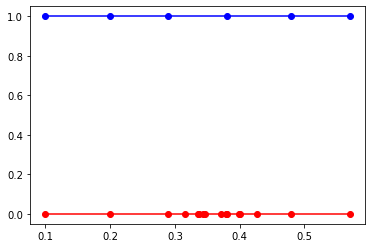

In [278]:
points, directions, all_distances = sample_points_weighted(rays, sigma_value, distances, num_samples, fine_samples)
fig, ax = plt.subplots()
ax.plot(distances.numpy()[0, :], torch.ones(num_samples), 'b-o')
ax.plot(all_distances.numpy()[0, :], torch.zeros(num_samples + fine_samples), 'r-o')